In [39]:
import pandas as pd
import numpy as np
import scipy as sc
from scipy import stats
import matplotlib.pyplot as plt
from datetime import datetime as dt, timedelta, date
import tqdm
tqdm.tqdm.pandas()
from numba import jit, njit, vectorize

import warnings
warnings.filterwarnings("ignore")

# Желтое такси

Нью-Йоркская комиссия по такси и лимузинам (TLC) предоставляет подробные анонимизированные данные о поездках клиентов с 2009 года. Машины, выкрашенные жёлтым, имеют право брать пассажиров на улицах в любом из пяти [боро](https://ru.wikipedia.org/wiki/Боро_(Нью-Йорк)) города.

Сырые данные о поездках в жёлтом такси можно найти на сайте [TLC](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page). Эти данные разбиты на файлы по месяцам. В каждом из файлов содержится следующая [информация](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf) о поездках:

- время начала поездки

- время окончания поездки

- долгота и широта точки начала поездки

- долгота и широта точки окончания поездки

- количество пассажиров

- расстояние по счётчику

- тип тарифа (одна из шести категорий)

- способ оплаты (одна из шести категорий)

- стоимость поездки по счётчику

- налог на счётчик

- доплата за поездки в пиковые часы и ночью

- доплата за проезд по платным дорогам

- доплата за проезд, взимаемая с каждой поездки с января 2015

- размер чаевых

- общая стоимость поездки

- провайдер данных (одна из двух категорий)

- бинарный флаг, показывающий, были ли данные о поездке получены немедленно после её окончания, или какое-то время хранились в памяти автомобиля.

Задача — научиться предсказывать количество поездок в ближайшие часы в районах Нью-Йорка; для простоты мы определим прямоугольные районы. Для того, чтобы её решить, сырые данные необходимо агрегировать по часам и районам. Агрегированные данные будут представлять собой почасовые временные ряды с количествами поездок из каждого района.

Задачу прогнозирования таких рядов можно решать с помощью авторегрессионных моделей, прогнозируя каждый ряд независимо. Ряды явно имеют сложную сезонность — суточную, недельную и годовую, поэтому для их моделирования необходимо использовать модель ARIMA с дополнительной регрессией на внешние признаки.

## 1. Загрузка, фильтрация  и предобработка данных 
**1.1**
Загрузите данные за май 2016 года. Выведите первые несколько строк и разберитесь, какие характеристики поездок записываются в датасет. Выведите размер датасета

In [19]:
# для тех, кто загружает урезанный датасет
taxi=pd.read_csv("Taxi-may2016-small.csv")

In [20]:
# вспоследствии вам необходимо будет скачать данные за январь-июнь 2016,
# которые  записаны в формате parquet. Можете воспользоваться кодом ниже:
#import sys
##!{sys.executable} -m pip install pyarrow
#parquet_file = 'taxi_2016_05.parquet'
#taxi = pd.read_parquet(parquet_file)

**1.2**
Проведите фильтрацию: удалите поездки с

- нулевой длительностью
- нулевым количеством пассажиров
- нулевым расстоянием поездки по счётчику
- координатами начала, не попадающими в прямоугольник Нью-Йорка

Нью-Йорк вписан в прямоугольник от -74.25559 до -73.70001 градусов долготы и от 40.49612 до 40.91553 широты.

In [21]:
taxi.describe()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,591843.000000,591843.000000,591843.000000,591843.000000,591843.000000,591843.000000,591843.000000,591843.000000,591843.000000,591843.000000,591843.000000,591843.000000,591843.000000,591843.000000,591843.000000,591843.000000
mean,1.529304,1.662370,3.057214,-73.030740,40.231897,1.045417,-73.107996,40.275329,1.349344,13.333549,0.329935,0.497368,1.831184,0.341535,0.299687,16.633248
std,0.499141,1.303796,3.928468,8.295098,4.569734,0.675679,7.951421,4.380551,0.493676,11.538116,0.461565,0.060850,2.573972,2.192410,0.012906,14.261097
min,1.000000,0.000000,0.000000,-78.951599,0.000000,1.000000,-80.383881,0.000000,1.000000,-146.000000,-35.500000,-0.500000,0.000000,-12.500000,-0.300000,-150.800000
25%,1.000000,1.000000,1.000000,-73.991806,40.736111,1.000000,-73.991188,40.734489,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.760000
50%,2.000000,1.000000,1.720000,-73.981354,40.753792,1.000000,-73.979210,40.754410,1.000000,9.500000,0.000000,0.500000,1.260000,0.000000,0.300000,12.300000
75%,2.000000,2.000000,3.260000,-73.965836,40.768696,1.000000,-73.961632,40.770191,2.000000,15.000000,0.500000,0.500000,2.450000,0.000000,0.300000,18.360000
max,2.000000,9.000000,802.900000,0.000000,48.006001,99.000000,0.000000,48.006001,5.000000,834.220000,50.000000,36.300000,250.000000,931.250000,0.300000,964.550000


In [22]:
taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-05-07 11:02:42,2016-05-07 11:28:15,3,10.28,-73.986076,40.759579,1,N,-73.861961,40.768581,1,31.0,0.0,0.5,6.00,5.54,0.3,43.34
1,2,2016-05-18 18:12:05,2016-05-18 18:34:01,1,2.44,-73.981369,40.770149,1,N,-73.952690,40.780560,1,14.5,1.0,0.5,4.08,0.00,0.3,20.38
2,1,2016-05-17 11:32:11,2016-05-17 11:51:55,1,0.90,-73.990501,40.740799,1,N,-73.987007,40.747669,1,12.0,0.0,0.5,2.55,0.00,0.3,15.35
3,2,2016-05-02 09:53:26,2016-05-02 10:03:53,6,1.35,-73.989388,40.758049,1,N,-73.982132,40.776508,2,8.5,0.0,0.5,0.00,0.00,0.3,9.30
4,1,2016-05-15 09:19:11,2016-05-15 09:31:09,3,2.60,-73.999825,40.718182,1,Y,-73.992493,40.749336,2,11.5,0.0,0.5,0.00,0.00,0.3,12.30


In [23]:
# Координаты прямоугольника Нью-Йорка
West=-74.25559
East=-73.70001
South=40.49612
North=40.91553

In [24]:
# Ваш код
# taxi_clean = taxi[(West <= taxi.pickup_longitude <= East) & \
#                   (South <= taxi.pickup_latitude <= North)]
taxi_clean = taxi[(West <= taxi.pickup_longitude) & (taxi.pickup_longitude <= East) & \
                  (South <= taxi.pickup_latitude) & (taxi.pickup_latitude <= North) & \
                  (taxi.trip_distance > 0) & \
                  (taxi.tpep_pickup_datetime != taxi.tpep_dropoff_datetime) & \
                  (taxi.passenger_count > 0)
                ]
taxi_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 581241 entries, 0 to 591842
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               581241 non-null  int64  
 1   tpep_pickup_datetime   581241 non-null  object 
 2   tpep_dropoff_datetime  581241 non-null  object 
 3   passenger_count        581241 non-null  int64  
 4   trip_distance          581241 non-null  float64
 5   pickup_longitude       581241 non-null  float64
 6   pickup_latitude        581241 non-null  float64
 7   RatecodeID             581241 non-null  int64  
 8   store_and_fwd_flag     581241 non-null  object 
 9   dropoff_longitude      581241 non-null  float64
 10  dropoff_latitude       581241 non-null  float64
 11  payment_type           581241 non-null  int64  
 12  fare_amount            581241 non-null  float64
 13  extra                  581241 non-null  float64
 14  mta_tax                581241 non-nu

**Подсказка** После фильтрации у вас должно остаться **581241** поездок

**1.2** Отбросьте минуты и секунды во времени начала поездки.

Вариант как можно это сделать: 
- преобразовать строковые данные из `tpep_pickup_datetime` в формат datetime (`pandas.to_datetime()`)
- округлить до часов с помощью функции `datetime.floor()`

In [27]:
# Ваш код
taxi_clean.tpep_pickup_datetime = pd.to_datetime(taxi_clean.tpep_pickup_datetime).dt.round('H')
taxi_clean.tpep_dropoff_datetime = pd.to_datetime(taxi_clean.tpep_dropoff_datetime).dt.round('H')

taxi_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 581241 entries, 0 to 591842
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               581241 non-null  int64         
 1   tpep_pickup_datetime   581241 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  581241 non-null  datetime64[ns]
 3   passenger_count        581241 non-null  int64         
 4   trip_distance          581241 non-null  float64       
 5   pickup_longitude       581241 non-null  float64       
 6   pickup_latitude        581241 non-null  float64       
 7   RatecodeID             581241 non-null  int64         
 8   store_and_fwd_flag     581241 non-null  object        
 9   dropoff_longitude      581241 non-null  float64       
 10  dropoff_latitude       581241 non-null  float64       
 11  payment_type           581241 non-null  int64         
 12  fare_amount            581241 non-null  floa

In [28]:
taxi_clean.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-05-07 11:00:00,2016-05-07 11:00:00,3,10.28,-73.986076,40.759579,1,N,-73.861961,40.768581,1,31.0,0.0,0.5,6.00,5.54,0.3,43.34
1,2,2016-05-18 18:00:00,2016-05-18 19:00:00,1,2.44,-73.981369,40.770149,1,N,-73.952690,40.780560,1,14.5,1.0,0.5,4.08,0.00,0.3,20.38
2,1,2016-05-17 12:00:00,2016-05-17 12:00:00,1,0.90,-73.990501,40.740799,1,N,-73.987007,40.747669,1,12.0,0.0,0.5,2.55,0.00,0.3,15.35
3,2,2016-05-02 10:00:00,2016-05-02 10:00:00,6,1.35,-73.989388,40.758049,1,N,-73.982132,40.776508,2,8.5,0.0,0.5,0.00,0.00,0.3,9.30
4,1,2016-05-15 09:00:00,2016-05-15 10:00:00,3,2.60,-73.999825,40.718182,1,Y,-73.992493,40.749336,2,11.5,0.0,0.5,0.00,0.00,0.3,12.30


**1.3.**  
- разбейте этот прямоугольник Нью-Йорка на 2500 одинаковых прямоугольных областей — по 50 интервалов вдоль каждой оси. 

Разбивать надо также, как в файле `regions.csv`, поэтому для начала 
- откройте его, выведите несколько первых строк датасета и поймите принцип, по которому проводится разбиение


In [29]:
# ваш код
regions = pd.read_csv('regions.csv', sep=';')
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


**1.4.**
Всем поездкам из датасета  присвойте соответствующие номера региона

Вариант того, как это можно сделать: создать функцию 

`set_reg(dataset, number_of_ceils=50, W=West, E=East, S=South, N=North)`

и применить ее к вашему датасету с поездками за май.

Также можно создать функцию для определения региона для единичного объекта по его координатам (потом пригодится для нахождения региона Empire State Building)

In [33]:
#ваш код
longitude_grid = np.linspace(West, East, 51)
latitude_grid = np.linspace(South, North, 51)

@njit
def find_reg(longitude, latitude):
    return (min(np.argwhere(longitude < longitude_grid))[0] - 1) * 50 + min(np.argwhere(latitude < latitude_grid))[0]

In [48]:

# reg = [0 for _ in range(len(taxi_clean))]
# print(len(reg))
# for i, r in tqdm.tqdm(taxi_clean.iterrows(), ncols=250):
#     reg[i] = find_reg(r.pickup_longitude, r.pickup_latitude)

# taxi_clean['region'] = reg

taxi_clean['region'] = taxi_clean.progress_apply(lambda row: find_reg(row['pickup_longitude'], row['pickup_latitude']), axis=1)

100%|██████████| 581241/581241 [00:12<00:00, 46719.80it/s]


In [49]:
taxi_clean.describe()

,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,region
count,581241.000000,581241.000000,581241.000000,581241.000000,581241.000000,581241.000000,581241.000000,581241.000000,581241.000000,581241.000000,581241.000000,581241.000000,581241.000000,581241.000000,581241.000000,581241.000000,581241.000000
mean,1.532431,1.665781,3.075889,-73.973007,40.750957,1.036345,-73.948987,40.738615,1.346514,13.285502,0.330048,0.497988,1.825358,0.340860,0.299813,16.579561,1277.151063
std,0.498948,1.307327,3.932656,0.038869,0.028555,0.455729,1.330717,0.733659,0.490305,11.138664,0.448977,0.034010,2.516776,2.194379,0.010513,13.889788,175.287549
min,1.000000,1.000000,0.010000,-74.250015,40.550056,1.000000,-80.383881,0.000000,1.000000,-74.000000,-4.500000,-0.500000,0.000000,-12.500000,-0.300000,-74.300000,32.000000
25%,1.000000,1.000000,1.020000,-73.991951,40.737194,1.000000,-73.991295,40.735607,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.760000,1181.000000
50%,2.000000,1.000000,1.740000,-73.981590,40.754368,1.000000,-73.979500,40.754871,1.000000,9.500000,0.000000,0.500000,1.320000,0.000000,0.300000,12.300000,1232.000000
75%,2.000000,2.000000,3.300000,-73.966690,40.768883,1.000000,-73.962471,40.770428,2.000000,15.000000,0.500000,0.500000,2.450000,0.000000,0.300000,18.360000,1287.000000
max,2.000000,9.000000,802.900000,-73.700180,40.906837,99.000000,0.000000,42.092148,4.000000,547.000000,20.200000,1.760000,250.000000,931.250000,0.300000,964.550000,2487.000000


In [ ]:
len(taxi_clean)

581241

ValueError: Length of values (1162482) does not match length of index (581241)

## 2. Создание датасета с данными, агрегированными по времени и региону

**2.1.** Агрегируйте данные за май 2016 года по часам и областям (можно использовать функцию stats.binned_statistic_2d). Не забудьте проверить, что идентификаторы, которые вы присваиваете ячейкам, соответствуют приложенному выше файлу

**Советы:**
- Для агрегации данных по часам вам нужно найти число часов в мае 2016.
Можно воспользоваться методом `pandas.Period('name_of_period').days_in_month`
- Функция `stats.binned_statistic_2d` - это по сути двухмерная гистограмма. Вам нужно разбить данные на двухмерные ячейки. Одно измерение - это часы, второе - регионы. Чтобы в одну ячейку попадал ровно 1 час и 1 регион, пропишите `bins=[binx,biny]`. А списки `binx` и `biny` можно задать с помощью `np.linspace()`
- Для нахождения периода, прошедшего с 1 мая до поездки, можете использовать такой код:
`delta=taxi1['hours']=(taxi1['tpep_pickup_datetime']-pd.to_datetime("2016-05-01 00:00:00", format='%Y-%m-%d %H:%M:%S'))`
- Вычислить число дней в периоде `delta`  можно с помощью `delta.days`, а секунд - `delta.seconds`


In [ ]:
# Ваш код


**2.2.**Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок

Посмотрите на образец в ячейке снизу. **Не запускайте ячейку!**

In [ ]:
# Не запускайте ячейку! Здесь образец того, как должен выглядеть датасет
df.head()

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
2016-05-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-05-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
## Ваш код

 ## 3. Анализ агрегированных данных

**3.1** Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building 

In [ ]:
#Longitude of Empire State Building -73.985664
#Latitude of Empire State Building: 40.748441
ESB_long = -73.985664
ESB_lat  =  40.748441

Определите регион, содержащий Empire State Building

In [ ]:
# Ваш код

Измените код из ячейки под свои названия датасетов и выведите график изменения числа поездок. **Не запускайте ячейку снизу - это образец!**

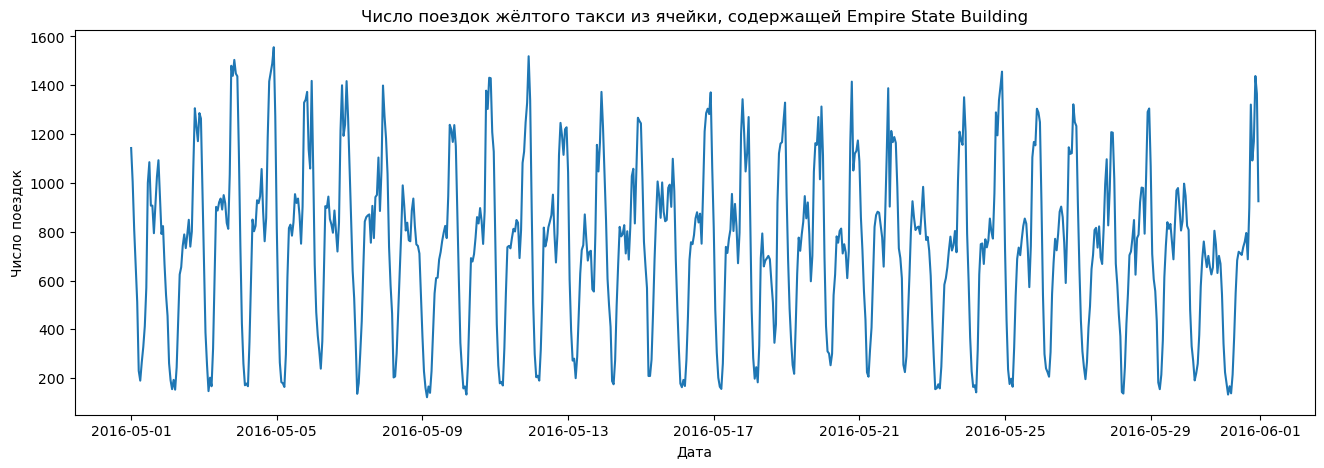

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(df.index, df.iloc[:,int(ESB_reg)], color='tab:blue')
plt.gca().set(title="Число поездок жёлтого такси из ячейки, содержащей Empire State Building", xlabel="Дата", ylabel="Число поездок")
plt.show()

**3.2** Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

In [ ]:
# Ваш код

**3.3.** Сохраните датасет с агрегированными данными в файл

In [ ]:
df.to_csv("Taxi-may2016-agregated.csv",index=False)